## Housing price prediction using the Ames Housing dataset via Kaggle

### General Strategy:
1. Replace null values
2. Remove outliers
3. Log plus one target scaling for a less skewed distribution
4. Standard scaling of numeric features
5. CatBoost model with grid search to effortlessly and effectively deal with a mix of numeric and categorical features

In [1]:
import os
for dirname, _, filenames in os.walk('kaggle\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle\input\house-prices-advanced-regression-techniques\data_description.txt
kaggle\input\house-prices-advanced-regression-techniques\sample_submission.csv
kaggle\input\house-prices-advanced-regression-techniques\test.csv
kaggle\input\house-prices-advanced-regression-techniques\train.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # numeric scaling
from sklearn.metrics import mean_squared_log_error # Metric for the competition
from catboost import CatBoostRegressor # Our model of choice
from sklearn.model_selection import GridSearchCV # Model tuning

In [3]:
df_train = pd.read_csv("kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_test = pd.read_csv("kaggle/input/house-prices-advanced-regression-techniques/test.csv")
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
print("Null values in training set: ", df_train.isnull().sum().sum())
print("Null values in testing set: ", df_test.isnull().sum().sum())

Null values in training set:  6965
Null values in testing set:  7000


## To get rid of null values, there are four different cases.

1. Categorical features where "None" is descriptive, for these I will replace them with "None".
2. Categorical features where "None" is not descriptive, for these I will replace them with the mode of that column.
3. Numerical features where zero is expected, for these I will replace them with 0.
4. Numerical features where zero is not expected, for these I will replace them with the mean of that column.

#### These are reasonable generalizations that will allow me to train off of the largest set possible and make predictions on a test set with null values.

In [7]:
replaceWithNone = [
    'Alley', 'Utilities', 'MasVnrType', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]

for col in replaceWithNone:
    df_train[col]=df_train[col].fillna('None')
    df_test[col]=df_test[col].fillna('None')

replaceWithMode = [
    'Electrical', 'MSZoning', 'Exterior1st', 'Exterior2nd', 
    'KitchenQual','SaleType','Functional'
]

for col in replaceWithMode:
    df_train[col]=df_train[col].fillna(df_train[col].mode()[0])
    df_test[col]=df_test[col].fillna(df_test[col].mode()[0])

replaceWithZero = [
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF' ,
    'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea'
]

for col in replaceWithZero:
    df_train[col]=df_train[col].fillna(0)
    df_test[col]=df_test[col].fillna(0)

replaceWithMean = [
    'LotFrontage'
]

for col in replaceWithMean:
    df_train[col]=df_train[col].fillna(df_train[col].mean())
    df_test[col]=df_test[col].fillna(df_test[col].mean())

In [8]:
print("Null values in training set: ", df_train.isnull().sum().sum())
print("Null values in testing set: ", df_test.isnull().sum().sum())

Null values in training set:  0
Null values in testing set:  0


In [9]:
# Dataset author recommends removing these outliers
df_train = df_train[df_train['GrLivArea'] < 4000]

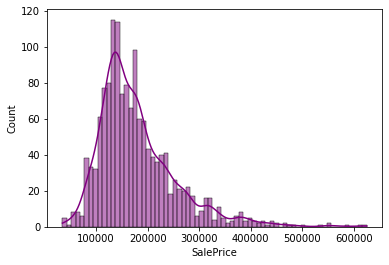

In [10]:
sns.histplot(df_train['SalePrice'], color="purple", bins=69, kde=True, kde_kws={ "bw_adjust" : 0.69 });

### Using a log1p transformation on the target will greatly assist my model. Trees like more normal distributions.

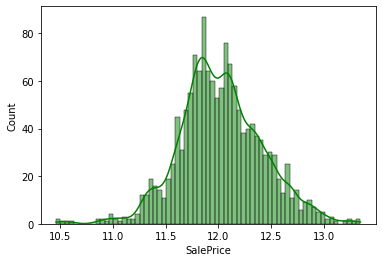

In [11]:
sns.histplot(np.log1p(df_train['SalePrice']), color="green", bins=69, kde=True, kde_kws={ "bw_adjust" : 0.69 });

In [12]:
X_train = df_train.drop(["SalePrice", "Id"], axis=1)
y_train = df_train["SalePrice"]
y_train_log1p = pd.DataFrame(np.log1p(y_train))
X_test = df_test.drop("Id", axis=1)

In [13]:
numeric_features = X_train.select_dtypes(exclude=["object"]).columns
categorical_features = df_train.select_dtypes(include=["object"]).columns

In [14]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train_scaled = X_train
X_train_scaled[numeric_features] = scaler.transform(X_train[numeric_features])
X_test_scaled = X_test
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

### CatBoost relieves me from encoding categorical values, while also being extremely effective for this use case.
### Grid search allows me to more easily tune our model by trying many configurations of hyperparameters.

In [15]:
# hyperparameters previously found with grid search
lr = 0.085
dep = 4
#################### UNCOMMENT TO RUN GRID SEARCH ####################
# model = CatBoostRegressor(iterations=500, cat_features=categorical_features, loss_function="MAE", logging_level="Silent")

# # Change these values to tweak the model
# grid = {"learning_rate": [0.0845, 0.08475, 0.085, 0.08575, 0.0865], "depth": [4]}

# grid_search_result = model.grid_search(grid, X=X_train, y=y_train)
# dep = grid_search_result["params"]["depth"]
# lr = grid_search_result["params"]["learning_rate"]
# print(grid_search_result["params"])
######################################################################

# I've found that adding iterations improves my score rapidly
# past this point I will have highly diminishing returns
model = CatBoostRegressor(iterations=50000, learning_rate=lr, \
                            depth=dep, cat_features=categorical_features, \
                                loss_function="MAE", logging_level="Silent")

model.fit(X_train_scaled, y_train_log1p);

In [16]:
train_predictions = np.expm1(model.predict(X_train_scaled))
print("Score on training set: ", mean_squared_log_error(y_train, train_predictions))

Score on training set:  0.0030570813543246917


In [17]:
# Output submission csv as detailed in Kaggle.
test_predictions = np.expm1(model.predict(X_test_scaled))
solution = pd.DataFrame( { "id": df_test.Id, "SalePrice": test_predictions } )
solution.to_csv("submissions\submissionCatboost.csv", index = False)